# Audio Declipping with Social Sparsity
    Paper Implementation: https://hal.science/hal-01002998/document

## Introduction
This notebook outlines the implementation of an audio declipping algorithm based on the paper "AUDIO DECLIPPING WITH SOCIAL SPARSITY". The algorithm aims to restore audio signals that have been subject to clipping by employing iterative thresholding algorithms and leveraging the principle of social sparsity.

## Problem Statement
Clipping occurs when the amplitude of an audio signal exceeds the maximum limit that can be represented in the digital domain, resulting in truncation. This often leads to distortion that is unpleasant to the ear. The goal of declipping is to estimate the original signal amplitudes that were lost due to clipping.

## Approach
The implementation will involve several key steps:
1. Representing the clipped audio signal in a sparse domain using a time-frequency dictionary.
2. Formulating and solving an optimization problem to find the best sparse representation that fits the clipped signal while respecting the clipping constraints.
3. Employing advanced thresholding operators to maintain social sparsity.
4. Iterating the process until convergence.


---

# Group members
* Jauroyon, Maxime
* Bhatt, Ragi

---

## Importing Libraries

In [17]:
#Import all the necesaaary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import os
import librosa
import scipy.io.wavfile as wavfile
from scipy.signal import periodogram, welch, convolve2d, stft, istft
from scipy.signal.windows import hann
from scipy.sparse import csr_matrix
import IPython
import soundfile as sf
from tqdm import tqdm
import pywt
import soundfile as sf  # or another library to read audio files

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing the music signal
 which will be the original signal
 and a second one for later (used in the course earlier)

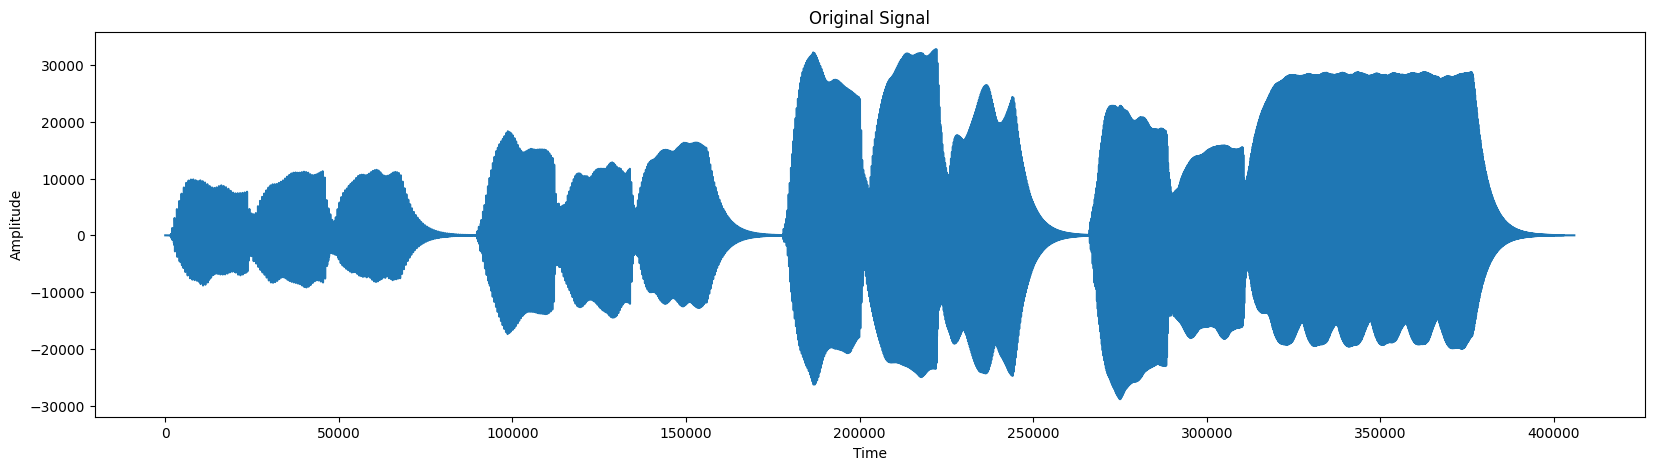

In [18]:
rate, original_signal = wavfile.read("./cello.wav")
rate2, original_signal2 = wavfile.read("./music.wav")

#Plotting the original signal
plt.figure(figsize=(20,5))
plt.plot(original_signal)
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#Playing the original signal
IPython.display.Audio(original_signal, rate=rate)

## Clipping the signal
 by applying a threshold to the signal

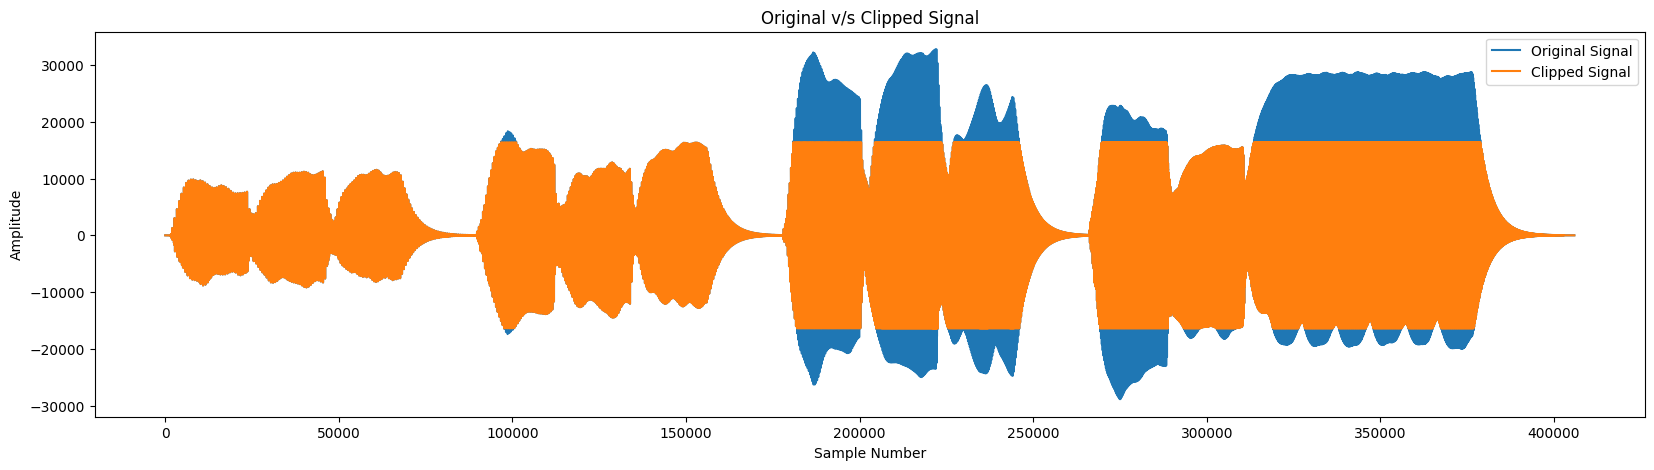

In [19]:
#Now will clip the original signal

def clip_original_signal(original_signal, clip_level=0.8):
    """
    This function clips the original signal.

    :param original_signal: The original signal
    :param clip_level: The clipping threshold
    :return: The clipped signal
    """
    #The range of the signal is [-1, 1]
    max_amplitude = np.max(np.abs(original_signal))

    #Now we will normalize the signal
    normalized_signal = original_signal / max_amplitude

    #Clipping the signal
    clipped_signal = np.clip(normalized_signal, -clip_level, clip_level)

    #Now we will denormalize the signal
    clipped_signal *= max_amplitude

    return clipped_signal

#Defining the clipping threshold
clip_level = 0.5
clipped_audio = clip_original_signal(original_signal, clip_level=clip_level)

#Plotting the clipped signal
plt.figure(figsize=(20,5))
plt.plot(original_signal, label="Original Signal")
plt.plot(clipped_audio, label="Clipped Signal")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Original v/s Clipped Signal")
plt.show()

#Playing the clipped signal
IPython.display.Audio(clipped_audio, rate=rate)

---

## Defining the thresholding functions as per mentioned in the paper:

- Lasso Operator:
        This operator adjusts coefficients by shrinking them based on their magnitude relative to a threshold value. 
        $$\widetilde{\alpha}_{tf}^{L} = S_{\lambda}^{L}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda}{|\alpha_{tf}|}\right)_+$$

- Windowed Group-Lasso (WGL) Operator:
        The WGL operator is a variation of the Lasso operator, which takes into account the neighborhood of each coefficient. 
        $$\widetilde{\alpha}_{tf}^{WGL} = S_{\lambda}^{WGL}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda}{\sqrt{\sum_{t' \in N(t)}|\alpha_{t'f}|^2}}\right)_+$$
        
In this equation, the denominator of the shrinkage term is the sum of the squares of the coefficients in the neighborhood N(t).


- Empirical Wiener (EW) Operator:
        This operator adjusts coefficients by shrinking them based on their magnitude relative to a threshold value. 
        $$\widetilde{\alpha}_{tf}^{EW} = S_{\lambda}^{EW}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda^2}{|\alpha_{tf}|^2}\right)_+$$

- Persistent Empirical Wiener (PEW) Operator:
        The PEW operator is a variation of the EW operator, which takes into account the neighborhood of each coefficient. 
        $$\widetilde{\alpha}_{tf}^{PEW} = S_{\lambda}^{PEW}(\alpha_{tf}) = \alpha_{tf} \left(1 - \frac{\lambda^2}{\sum_{t' \in N(t)}|\alpha_{t'f}|^2}\right)_+$$
        
In this equation, the denominator of the shrinkage term is the sum of the squares of the coefficients in the neighborhood N(t).
​



In [20]:
#Defining the threshold function: EW and Lasso

def thresh_lasso(u,t):return np.maximum(1-t/abs(u), 0)*u

def thresh_ew(u,t):return np.maximum(1-t**2/abs(u)**2, 0)*u

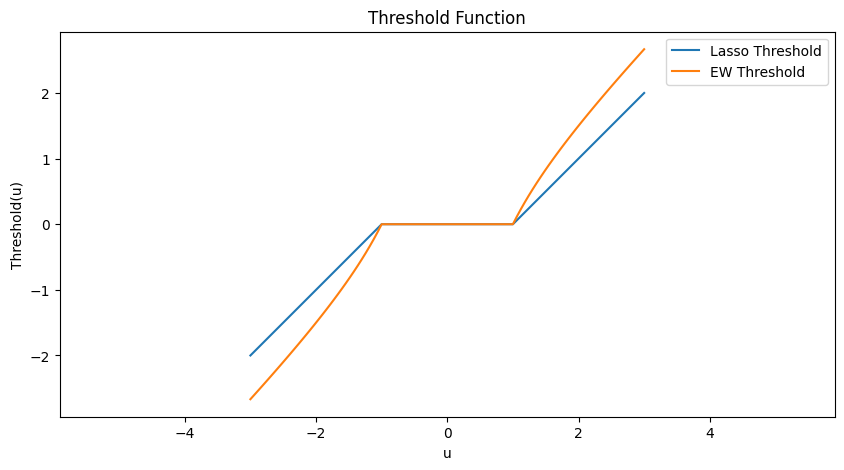

In [21]:
#Plotting the threshold function
x = np.linspace(-3, 3, 100)
plt.figure(figsize=(10,5))
plt.plot(x, thresh_lasso(x, 1), label="Lasso Threshold")
plt.plot(x, thresh_ew(x, 1), label="EW Threshold")
plt.title("Threshold Function")
plt.xlabel("u")
plt.ylabel("Threshold(u)")
plt.legend()
plt.axis('equal')
plt.show()

In [22]:
#Defining the threshold function: PEW and WGL
    
def thresh_pew(alpha, lambda_val, neighborhood, neighborhood_size=3):
    """
    Apply the Persistent Empirical Wiener (PEW) operator.

    :param alpha: The input coefficients (2D numpy array).
    :param lambda_val: The threshold value.
    :param neighborhood: Function that returns the neighborhood indices for a given index.
    :param neighborhood_size: The size of the neighborhood.
    :return: The modified coefficients after applying the PEW operator.
    """
    alpha_tilde = np.zeros_like(alpha)

    for t in range(alpha.shape[0]):
        for f in range(alpha.shape[1]):
            # Calculate the sum of squares in the neighborhood
            sum_of_squares = sum(abs(alpha[t_prime, f_prime])**2 for t_prime,f_prime in neighborhood((t,f), alpha, neighborhood_size))
            # Apply the PEW operator
            factor = np.maximum(1 - lambda_val**2 / sum_of_squares, 0)
            alpha_tilde[t, f] = alpha[t, f] * factor

    return alpha_tilde

def thresh_wgl(alpha, lambda_val, neighborhood, neighborhood_size=3):
    """
    Apply the Weighted Group Lasso (WGL) operator.

    :param alpha: The input coefficients (2D numpy array).
    :param lambda_val: The threshold value.
    :param neighborhood: Function that returns the neighborhood indices for a given index.
    :param neighborhood_size: The size of the neighborhood.
    :return: The modified coefficients after applying the WGL operator.
    """
    alpha_tilde = np.zeros_like(alpha)

    for t in range(alpha.shape[0]):
        for f in range(alpha.shape[1]):
            # Calculate the sum of squares in the neighborhood
            sum_of_squares = sum(abs(alpha[t_prime, f_prime])**2 for t_prime,f_prime in neighborhood((t,f), alpha, neighborhood_size))
            # Apply the WGL operator
            factor = np.maximum(1 - lambda_val / np.sqrt(sum_of_squares), 0)
            alpha_tilde[t, f] = alpha[t, f] * factor

    return alpha_tilde


# Function that takes an index (or coordinates) 
# of a coefficient and returns the indices (or coordinates) of 
# coefficients in its neighborhood
def neighborhood_function(index,alpha, neighborhood_size=0):
    """
    Return the neighborhood indices for a given index.

    :param index: The index of the coefficient.
    :param alpha: The coefficients (2D numpy array).
    :param neighborhood_size: The size of the neighborhood.
    :return: The indices of the coefficients in the neighborhood.
    """
    
    if neighborhood_size == 0:
        return [(index[0], index[1])]
    # return the square neighborhood around the index
    else:
        neighborhood = []
        for t in range(index[0] - neighborhood_size, index[0] + neighborhood_size + 1):
            for f in range(index[1] - neighborhood_size, index[1] + neighborhood_size + 1):
                if 0 <= t < alpha.shape[0] and 0 <= f < alpha.shape[1]:
                    neighborhood.append((t, f))
        return neighborhood

### WGL and PEW with unit-neighborhood (with only one coefficient) coincide with the Lasso and EW operator, respectively.

(10, 10)


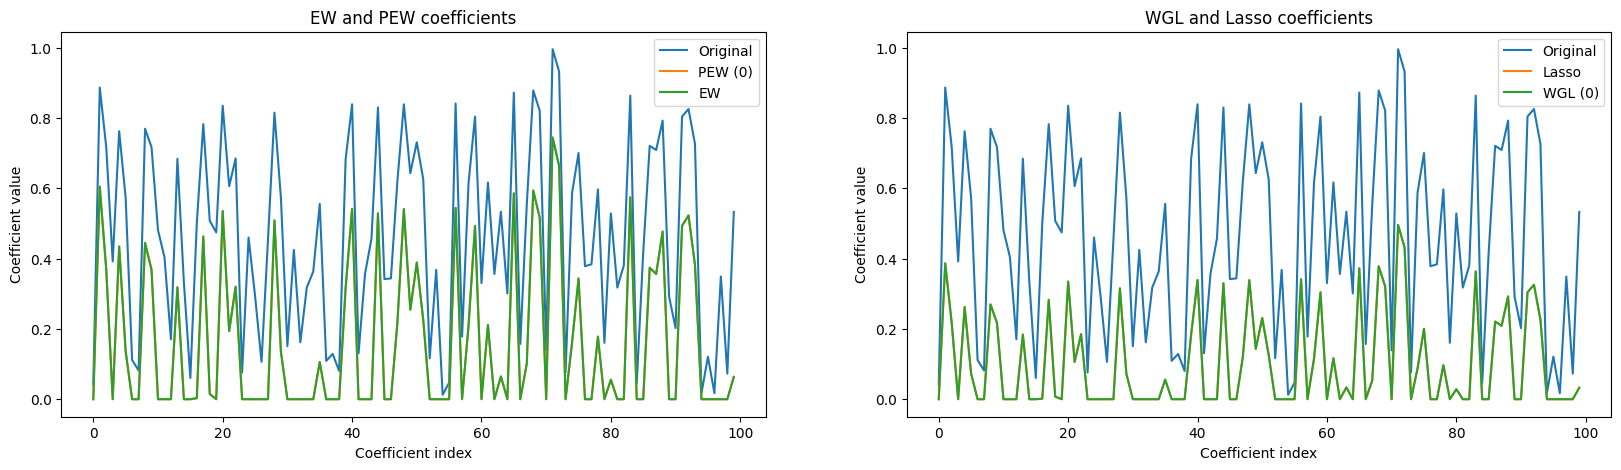

In [23]:
# Example usage
alpha = np.random.rand(10, 10)  # Replace with your actual coefficients
print(alpha.shape)
lambda_val = 0.5  # Set your lambda value
pew_output = thresh_pew(alpha, lambda_val, neighborhood_function, neighborhood_size=0)
ew_output = thresh_ew(alpha, lambda_val)

plt.figure(figsize=(20,5))

# PLotting the pew operator
plt.subplot(1, 2, 1)
plt.plot(alpha.flatten(), label='Original')
plt.plot(pew_output.flatten(), label='PEW (0)')
plt.plot(ew_output.flatten(), label='EW')
plt.legend()
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('EW and PEW coefficients')


# PLotting the wgl operator and lasso operator
plt.subplot(1, 2, 2)
wgl_output = thresh_wgl(alpha, lambda_val, neighborhood_function, neighborhood_size=0)
lasso_output = thresh_lasso(alpha, lambda_val)
plt.plot(alpha.flatten(), label='Original')
plt.plot(lasso_output.flatten(), label='Lasso')
plt.plot(wgl_output.flatten(), label='WGL (0)')
plt.legend()
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('WGL and Lasso coefficients')

plt.show()

### WGL and PEW also behave differently when the neighborhood is larger than one coefficient.

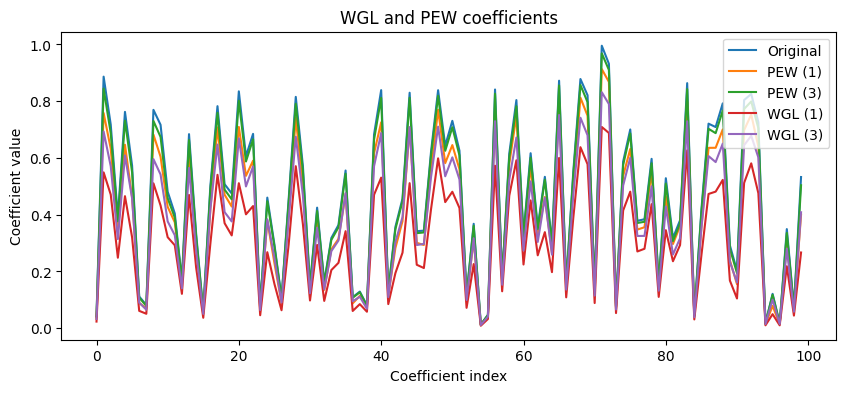

In [24]:
# Plotting the pew and wgl operator
wgl_output_1 = thresh_wgl(alpha, lambda_val, neighborhood_function, neighborhood_size=1)
pew_output_1 = thresh_pew(alpha, lambda_val, neighborhood_function, neighborhood_size=1)
wgl_output_3 = thresh_wgl(alpha, lambda_val, neighborhood_function, neighborhood_size=3)
pew_output_3 = thresh_pew(alpha, lambda_val, neighborhood_function, neighborhood_size=3)
plt.figure(figsize=(10, 4))
plt.plot(alpha.flatten(), label='Original')
plt.plot(pew_output_1.flatten(), label='PEW (1)')
plt.plot(pew_output_3.flatten(), label='PEW (3)')
plt.plot(wgl_output_1.flatten(), label='WGL (1)')
plt.plot(wgl_output_3.flatten(), label='WGL (3)')
plt.legend()
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('WGL and PEW coefficients')
plt.show()

---

## Defining the PHI and PHI adjoint in case of the Gambor frame:


In [25]:
#Defining the phi adjoint function
def phi_adjoint(original_signal, rate, window_length, time_shift):
    #Computing the STFT of the original signal
    _, _, Zxx = stft(original_signal, fs=rate, window='hann', nperseg=window_length, noverlap=window_length-time_shift)

    return Zxx

#defining the phi function
def phi(transformed_signal, rate, window_length, time_shift, original_length):
    #Reconstructing the signal from the STFT
    _, signal = istft(transformed_signal, fs=rate, window='hann', nperseg=window_length, noverlap=window_length-time_shift)

    return signal[:original_length]

---

## Performance of the declipping is evaluated using the SNRm

In [26]:
#Defining the SNR_m function

def SNR_m(y, y_hat, Mc):
    #defining the masking matrix
    masked_y = Mc.dot(y)
    masked_error = Mc.dot(y - y_hat)

    #Norms of the masked signal and the masked error
    masked_y_norm = np.linalg.norm(masked_y)
    masked_error_norm = np.linalg.norm(masked_error)

    #Computing the SNR
    SNR = 20 * np.log10(masked_y_norm / masked_error_norm)

    return SNR

---

## Defining the relaxed version of ISTA

In [27]:
def ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta,lambda_=None, max_iter=1000, y_ground_truth=None, shrinkage='EW', neighborhood_size=3, lambda_step=250):
    """
    Apply the Iterative Soft Thresholding Algorithm (ISTA) with relaxation.

    :param y: The input signal.
    :param window: The window function.
    :param window_length: The window length.
    :param time_shift: The time shift.
    :param M_r: The masking matrix for the relaxed constraint.
    :param M_c: The masking matrix for the clipping constraint.
    :param gamma: The relaxation parameter.
    :param delta: The step size.
    :param lambda_: The threshold value if fixed.
    :param max_iter: The maximum number of iterations.
    :param y_ground_truth: The ground truth signal.
    :param shrinkage: The shrinkage parameter.
    :param neighborhood_size: The size of the neighborhood.
    :param lambda_step: The step size for the threshold value decay.
    :return: The recovered signal and the SNR for each iteration.
    """
    
    alpha = np.zeros_like(phi_adjoint(y, rate, window_length, time_shift))
    z = np.zeros_like(alpha)

    y_r = M_r * y
    theta_clip = M_c * y
    
    if lambda_ is None:
        # create the decaying values logarithmically spaced from λ = 0.1 to λ = 0.0001 every lambda_step iterations
        lambda_values = np.logspace(-2, -4, max_iter // lambda_step)
    else:
        lambda_values = [lambda_] * (max_iter // lambda_step)

    # save the SNR for each iteration
    SNRs = []

    progress= tqdm(range(max_iter))
    for k in progress:

        #Computing the gradient
        g1 = -phi_adjoint(M_r.T * (y_r - M_r * phi(z, rate, window_length, time_shift, y.shape[0])), rate, window_length, time_shift)
        g2 = -phi_adjoint(M_c.T * (np.clip(theta_clip - M_c * phi(z, rate, window_length, time_shift, y.shape[0]), 0, np.inf)), rate, window_length, time_shift)
    
        lambda_= lambda_values[k // lambda_step]
        
        # catch division by zero / runtime and ignore the warning
        with np.errstate(divide='ignore') and np.errstate(invalid='ignore'):
            #Now we will take alpha and then update it with the threshold function
            # depends on the shrinkage parameter
            if shrinkage == 'EW':
                alpha_new = thresh_ew(z - (1 / delta) * (g1 + g2), lambda_ / delta)
            elif shrinkage == 'PEW':
                alpha_new = thresh_pew(z - (1 / delta) * (g1 + g2), lambda_ / delta, neighborhood_function, neighborhood_size)
            elif shrinkage == 'Lasso':
                alpha_new = thresh_lasso(z - (1 / delta) * (g1 + g2), lambda_ / delta)
            elif shrinkage == 'WGL':
                alpha_new = thresh_wgl(z - (1 / delta) * (g1 + g2), lambda_ / delta, neighborhood_function, neighborhood_size)
            else:
                raise ValueError(f'Unknown shrinkage parameter: {shrinkage}')

        #Now we will update z
        z = alpha_new + gamma * (alpha_new - alpha)

        #Checking the SNR
        if y_ground_truth is not None:
            SNR = SNR_m(y_ground_truth, phi(alpha_new, rate, window_length, time_shift, y.shape[0]), M_c)

        #Checking the convergence
        diff = np.linalg.norm(alpha_new - alpha)
        progress.set_description(f'Iteration: {k}, SNR: {SNR:.2f}, Diff: {diff:.2f}')
        if diff < 1e-3:
            break

        alpha = alpha_new

        SNRs.append(SNR)

    return phi(alpha, rate, window_length, time_shift, y.shape[0]), SNRs



---

## Hyperparameters for the the algorithm:

In [28]:
#Definiing the hyperpaparameters
window_length = 1024
time_shift = 256
lambda_ = 0.01
gamma = 0.9
max_iter = 2000

---

## Reconstructing the Clipped Audio
signal is range-normalized, in order to
have sample values lower than 1, and clipped at level 0.5

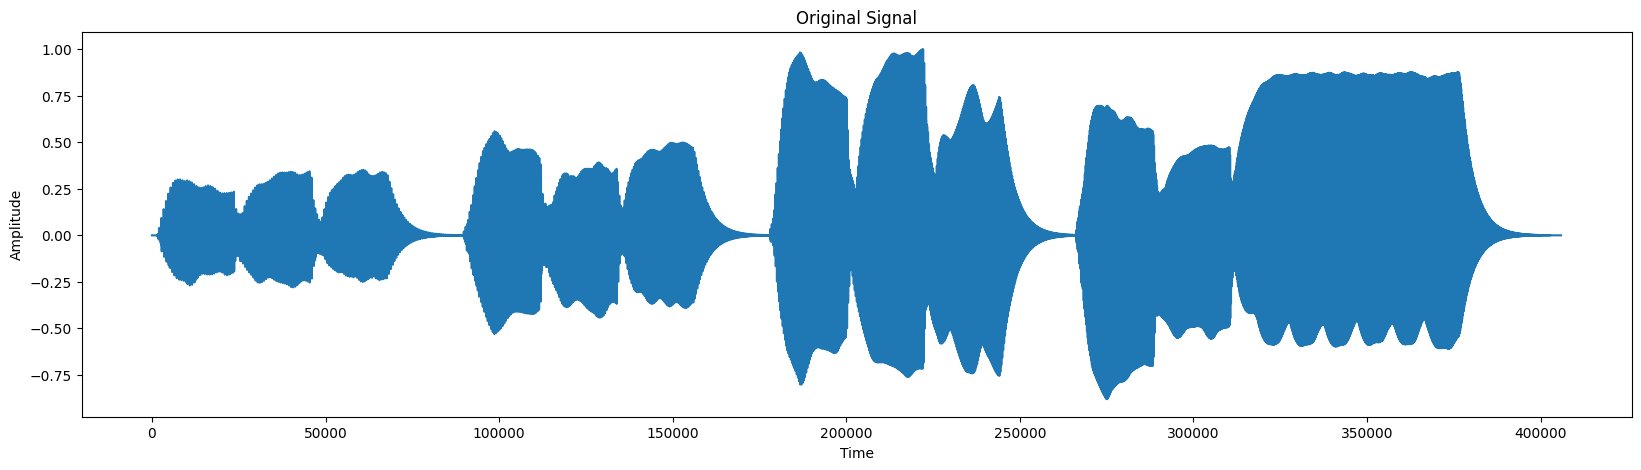

In [56]:
# you should normalize the signal: y= y / max(abs(y))
normalized_signal = original_signal / np.max(np.abs(original_signal))

#Plotting the original signal
plt.figure(figsize=(20,5))
plt.plot(normalized_signal)
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


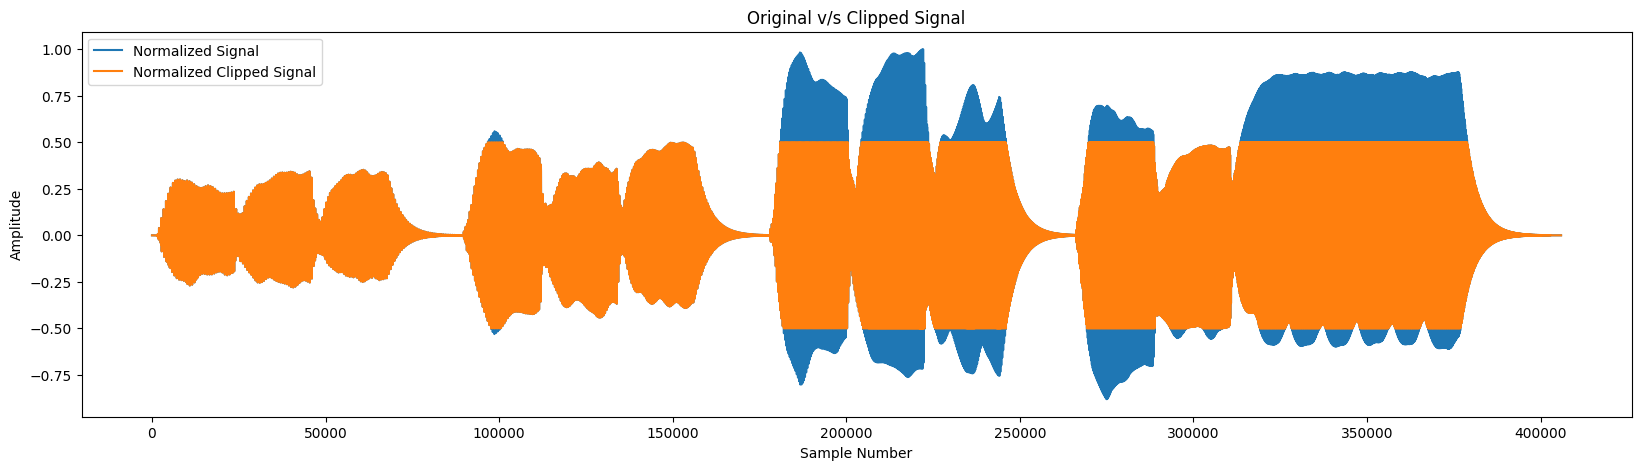

In [57]:
#Defining the clipping threshold
clip_level = 0.5
normalized_clipped_audio = clip_original_signal(normalized_signal, clip_level=clip_level)

#Plotting the clipped signal
plt.figure(figsize=(20,5))
plt.plot(normalized_signal, label="Normalized Signal")
plt.plot(normalized_clipped_audio, label="Normalized Clipped Signal")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Original v/s Clipped Signal")
plt.show()

### Computing the parameters of the algorithm that depends on the signal

In [58]:
def get_parameters(normalized_signal, normalized_clipped_audio, window_length, time_shift, rate):
    y_ground_truth = normalized_signal
    y = normalized_clipped_audio
    window = window_length

    upper_y = np.max(y)
    lower_y = np.min(y)

    reliable_indices = np.where(y==upper_y,0 ,1)
    reliable_indices = np.where(y==lower_y, 0, reliable_indices)
    reliable_indices = reliable_indices.nonzero()[0]
    row_indices = np.arange(reliable_indices.shape[0])
    col_indices = reliable_indices
    data = np.ones(reliable_indices.shape[0])
    M_r = csr_matrix((data, (row_indices, col_indices)), shape=(reliable_indices.shape[0], y.shape[0]))

    clipped_indices = np.where(y==upper_y, 1, 0)
    clipped_indices = np.where(y==lower_y, 1, clipped_indices)
    clipped_indices = clipped_indices.nonzero()[0]
    row_indices = np.arange(clipped_indices.shape[0])
    col_indices = clipped_indices
    data = np.ones(clipped_indices.shape[0])
    M_c = csr_matrix((data, (row_indices, col_indices)), shape=(clipped_indices.shape[0], y.shape[0]))

    #The delta value
    y_transformed = phi_adjoint(y, rate, window_length, time_shift)
    y_reconstructed = phi(y_transformed, rate, window_length, time_shift, y.shape[0])
    delta = np.linalg.norm(y_reconstructed) / np.linalg.norm(y)

    return y_ground_truth, y, window, M_r, M_c, delta, clipped_indices, reliable_indices

### Running the algorithms

In [59]:
y_ground_truth, y, window, M_r, M_c, delta, clipped_indices_5, reliable_indices_5 = get_parameters(normalized_signal, normalized_clipped_audio, window_length, time_shift, rate)

In [60]:
# EW
reconstructed_signal_ew_5, SNRs_ew_5 = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='EW')

  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_438/1398207116.py:5: RuntimeWarning: divide by zero encountered in divide
  def thresh_ew(u,t):return np.maximum(1-t**2/abs(u)**2, 0)*u
Iteration: 1199, SNR: 15.14, Diff: 0.00:  60%|█████▉    | 1199/2000 [05:49<03:53,  3.43it/s]


In [34]:
# Lasso
reconstructed_signal_lasso_5, SNRs_lasso_5 = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='Lasso')

  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_438/1398207116.py:3: RuntimeWarning: divide by zero encountered in divide
  def thresh_lasso(u,t):return np.maximum(1-t/abs(u), 0)*u
Iteration: 193, SNR: 7.70, Diff: 0.00:  10%|▉         | 193/2000 [01:26<13:28,  2.23it/s]


### Unfortunatey, the PEW and WGL operators are taking too much time to compute, so we will only use the Lasso and EW operators

In [35]:
# PEW
# reconstructed_signal_pew, SNRs_pew = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='PEW', neighborhood_size=1, lambda_step=25)

In [36]:
# WGL
# reconstructed_signal_wgl, SNRs_wgl = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='WGL', neighborhood_size=1, lambda_step=25)


### Computing the EW algo for all the clipping levels from 0.1 to 0.9

In [37]:
# Computing the EW algo for all the clipping levels from 0.1 to 0.9
SNRs_ew = []
clipping_levels = np.linspace(0.1, 0.9, 9)

for clip_level in clipping_levels:
    normalized_clipped_audio = clip_original_signal(normalized_signal, clip_level=clip_level)
    y_ground_truth, y, window, M_r, M_c, delta, clipped_indices, reliable_indices = get_parameters(normalized_signal, normalized_clipped_audio, window_length, time_shift, rate)
    reconstructed_signal_ew, SNRs = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='EW')
    SNRs_ew.append(SNRs)

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_438/1398207116.py:5: RuntimeWarning: divide by zero encountered in divide
  def thresh_ew(u,t):return np.maximum(1-t**2/abs(u)**2, 0)*u
Iteration: 970, SNR: 34.40, Diff: 0.00:  48%|████▊     | 970/2000 [05:29<05:50,  2.94it/s]  


---

### Plotting the results for the EW algo at all the clipping levels

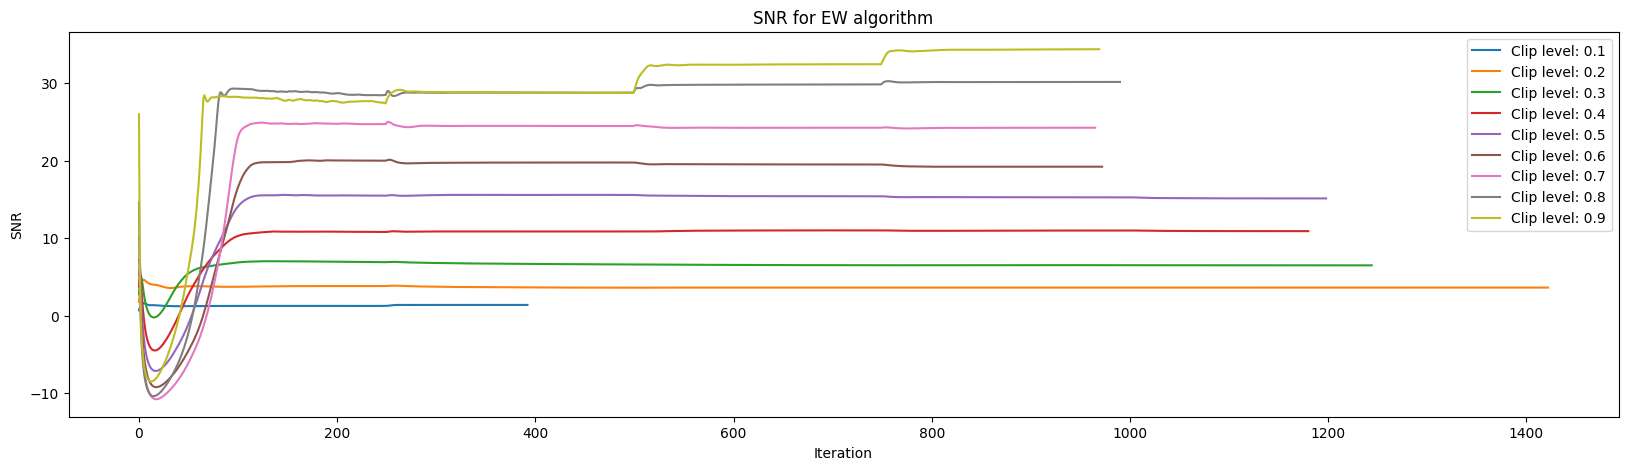

In [38]:
# plot the SNR for each clipping level
plt.figure(figsize=(20,5))
for i, SNRs in enumerate(SNRs_ew):
    plt.plot(SNRs, label=f'Clip level: {clipping_levels[i]:.1f}')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR')
plt.title('SNR for EW algorithm')
plt.show()

### We can observe that it quickly attains a high SNRm, but then it stagnates and the decaying of lambda does not help much except for clip levels 0.8 and 0.9

### Plotting the results at clipping level 0.5 for all the algorithms

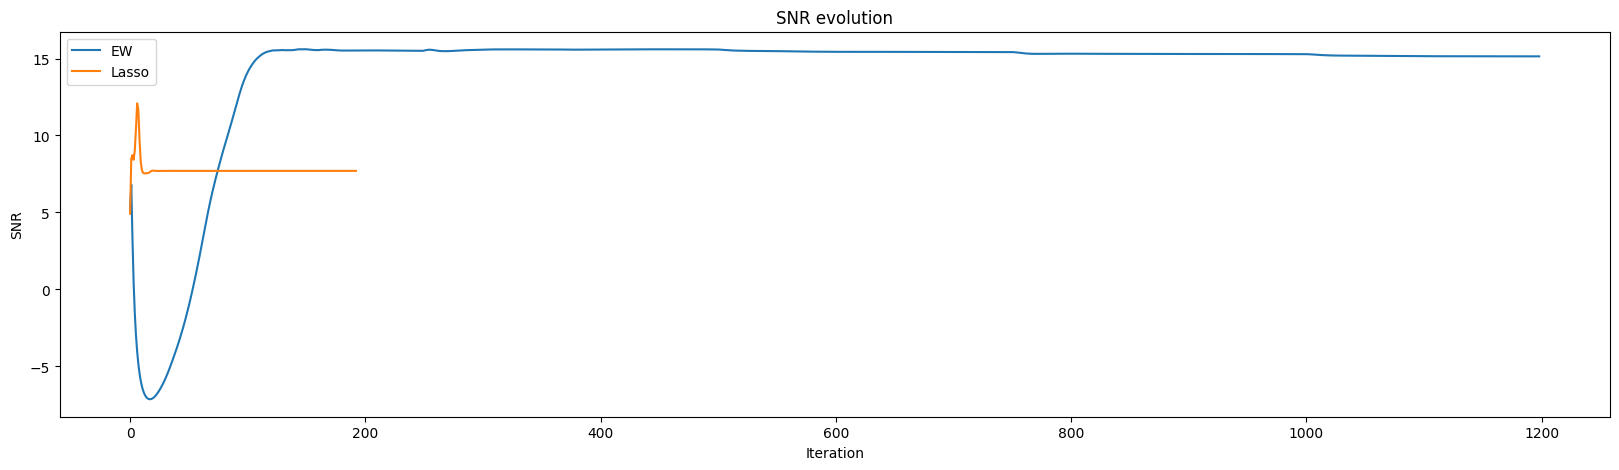

In [39]:
# plot the SNR
plt.figure(figsize=(20,5))
plt.plot(SNRs_ew_5, label='EW')
plt.plot(SNRs_lasso_5, label='Lasso')
# plt.plot(SNRs_pew, label='PEW')
# plt.plot(SNRs_wgl, label='WGL')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("SNR")
plt.title("SNR evolution") 
plt.show()


In [61]:
#Only using the clipped pieces of the reconstructed signal

final_reconstructed_signal_ew = np.copy(normalized_clipped_audio)
final_reconstructed_signal_ew[clipped_indices_5] = reconstructed_signal_ew_5[clipped_indices_5]

### Analyzing the results for EW at declipping level 0.5

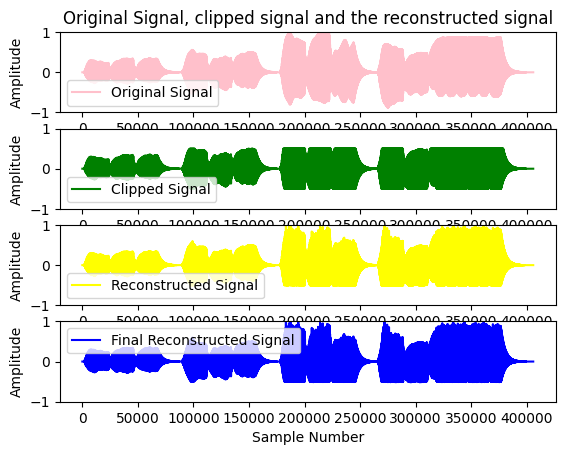

In [62]:
#Plotting the original signal and the reconstructed signal
plt.subplot(4,1,1)
plt.plot(normalized_signal, label="Original Signal", color="pink")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Original Signal, clipped signal and the reconstructed signal")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,2)
plt.plot(normalized_clipped_audio, label="Clipped Signal", color="green")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,3)
plt.plot(reconstructed_signal_ew_5, label="Reconstructed Signal", color="yellow")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,4)
plt.plot(final_reconstructed_signal_ew, label="Final Reconstructed Signal", color="blue")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.show()

### The negative part of the signal is not well reconstructed, but the positive part is pretty well reconstructed

In [63]:
# save it as a wav file
sf.write('reconstructed_signal_cello.wav', reconstructed_signal_ew_5, rate)


#Playing the reconstructed signal
print("Playing the reconstructed signal")
IPython.display.Audio(reconstructed_signal_ew_5, rate=rate)

Playing the reconstructed signal


In [64]:
# save it as a wav file
sf.write('final_reconstructed_signal_cello.wav', final_reconstructed_signal_ew, rate)

#Playing the final reconstructed signal
print("Playing the final reconstructed signal")
IPython.display.Audio(final_reconstructed_signal_ew, rate=rate)

Playing the final reconstructed signal


---

## Doing the same for the music.wav file
this time the reconstruction in the negative part of the signal is not as good as the positive part but still observable
compared to what we had with cello.wav

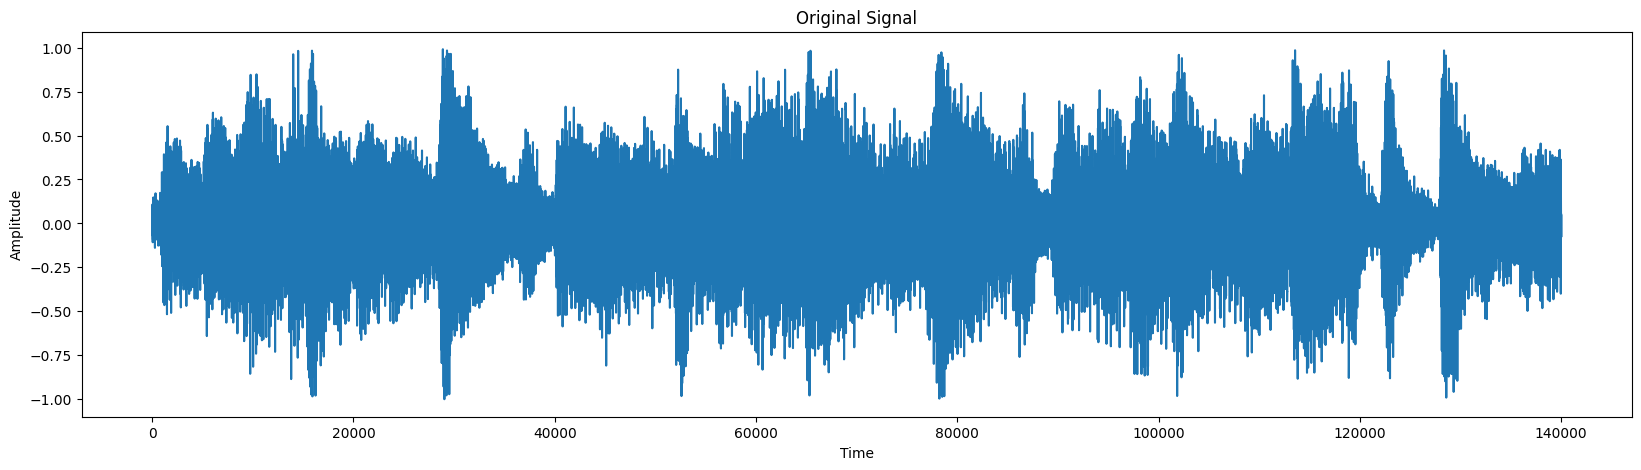

In [65]:
normalized_signal2 = original_signal2 / np.max(np.abs(original_signal2))
clip_level = 0.5
normalized_clipped_audio2 = clip_original_signal(normalized_signal2, clip_level=clip_level)

#Plotting the original signal
plt.figure(figsize=(20,5))
plt.plot(normalized_signal2)
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Display the original signal
IPython.display.Audio(normalized_signal2, rate=rate2)

Iteration: 0, SNR: 5.70, Diff: 3.65:   0%|          | 1/2000 [00:00<04:55,  6.77it/s]

Iteration: 208, SNR: 8.60, Diff: 0.00:  10%|█         | 208/2000 [00:32<04:38,  6.44it/s]


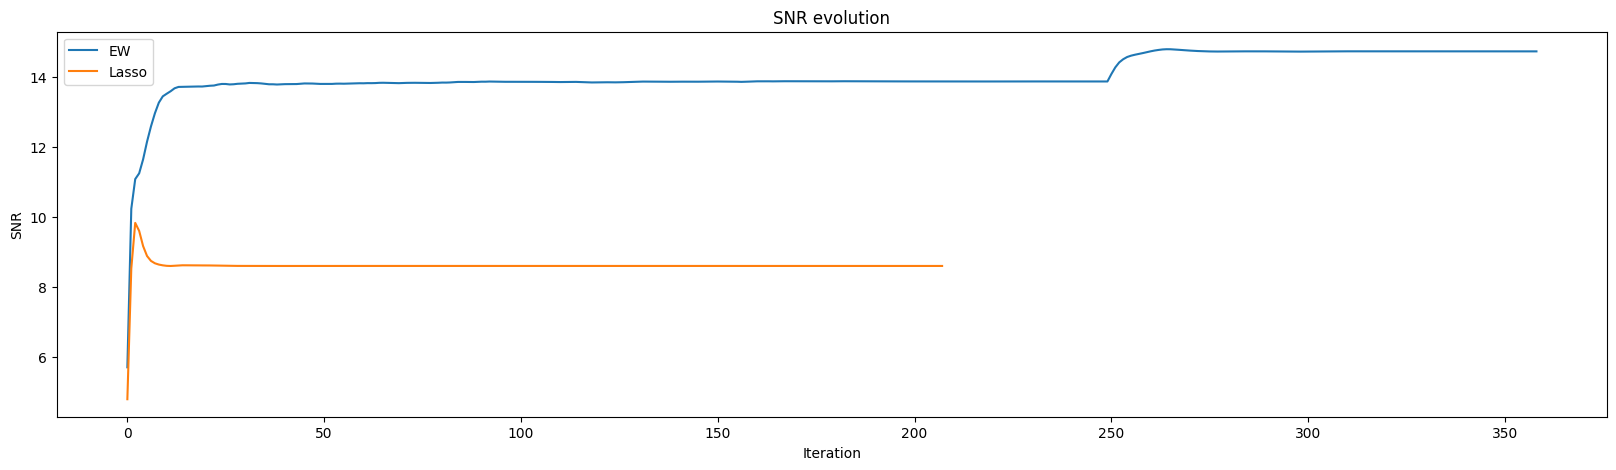

In [66]:
# Run the ISTA algorithm with EW shrinkage
y_ground_truth, y, window, M_r, M_c, delta, clipped_indices, reliable_indices = get_parameters(normalized_signal2, normalized_clipped_audio2, window_length, time_shift, rate2)
reconstructed_signal_ew_5, SNRs_ew_5 = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='EW')

# Lasso
reconstructed_signal_lasso_5, SNRs_lasso_5 = ista_relaxed(y, window, window_length, time_shift, M_r, M_c, gamma, delta, max_iter=max_iter, y_ground_truth=y_ground_truth, shrinkage='Lasso')

# plot the SNR
plt.figure(figsize=(20,5))
plt.plot(SNRs_ew_5, label='EW')
plt.plot(SNRs_lasso_5, label='Lasso')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("SNR")
plt.title("SNR evolution")
plt.show()

In [67]:
#Only using the clipped pieces of the reconstructed signal

final_reconstructed_signal_ew = np.copy(normalized_clipped_audio2)
final_reconstructed_signal_ew[clipped_indices] = reconstructed_signal_ew_5[clipped_indices]

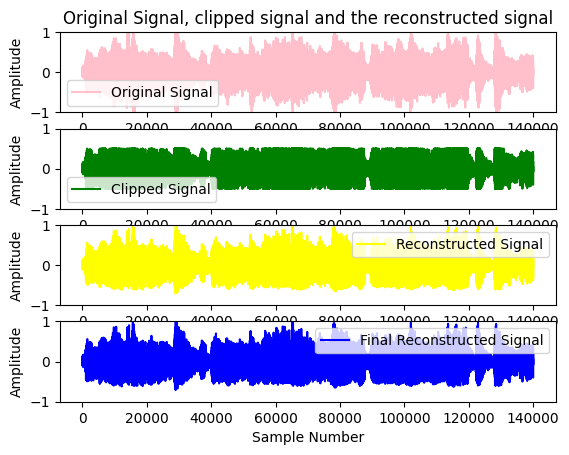

In [68]:
#Plotting the original signal and the reconstructed signal
plt.subplot(4,1,1)
plt.plot(normalized_signal2, label="Original Signal", color="pink")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Original Signal, clipped signal and the reconstructed signal")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,2)
plt.plot(normalized_clipped_audio2, label="Clipped Signal", color="green")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,3)
plt.plot(reconstructed_signal_ew_5, label="Reconstructed Signal", color="yellow")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.subplot(4,1,4)
plt.plot(final_reconstructed_signal_ew, label="Final Reconstructed Signal", color="blue")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
# plt.ylim(-50000, 50000)
plt.ylim(-1, 1)
plt.show()

In [69]:
# save it as a wav file
sf.write('reconstructed_signal_music.wav', reconstructed_signal_ew_5, rate2)


#Playing the reconstructed signal
print("Playing the reconstructed signal")
IPython.display.Audio(reconstructed_signal_ew_5, rate=rate2)

Playing the reconstructed signal


In [70]:
# save it as a wav file
sf.write('final_reconstructed_signal_music.wav', final_reconstructed_signal_ew, rate2)

#Playing the final reconstructed signal
print("Playing the final reconstructed signal")
IPython.display.Audio(final_reconstructed_signal_ew, rate=rate2)

Playing the final reconstructed signal


### We observe that the reconstruction is better for the music signal than the cello signal
but the audio from the final version of the music signal is not as good as the reconstructed one